In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [ ]:
!pip install -U albumentations
import albumentations as album





In [ ]:
from google.colab import files
uploaded = files.upload()

Saving metadata.csv to metadata.csv


In [ ]:
import pandas as pd 
import io
df=pd.read_csv(io.BytesIO(uploaded['metadata.csv']))
print(df)


     frame_id  sequence_id  ...        png_image_path             png_mask_path
0           1            1  ...    PNG/Original/1.png    PNG/Ground Truth/1.png
1          10            1  ...   PNG/Original/10.png   PNG/Ground Truth/10.png
2         100            5  ...  PNG/Original/100.png  PNG/Ground Truth/100.png
3         101            5  ...  PNG/Original/101.png  PNG/Ground Truth/101.png
4         102            5  ...  PNG/Original/102.png  PNG/Ground Truth/102.png
..        ...          ...  ...                   ...                       ...
607        95            5  ...   PNG/Original/95.png   PNG/Ground Truth/95.png
608        96            5  ...   PNG/Original/96.png   PNG/Ground Truth/96.png
609        97            5  ...   PNG/Original/97.png   PNG/Ground Truth/97.png
610        98            5  ...   PNG/Original/98.png   PNG/Ground Truth/98.png
611        99            5  ...   PNG/Original/99.png   PNG/Ground Truth/99.png

[612 rows x 6 columns]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
!pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [ ]:
cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d balraj98/cvcclinicdb

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
import glob

Original_names=glob.glob("/content/drive/MyDrive/CVC-ClinicDB/Original/*.tif")

Original_names.sort()


In [ ]:
print(Original_names)

['/content/drive/MyDrive/CVC-ClinicDB/Original/1.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/10.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/100.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/101.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/102.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/103.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/104.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/105.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/106.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/107.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/108.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/109.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/11.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/110.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/111.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/112.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/113.tif', '/content/drive/MyDrive/CVC-ClinicDB/Original/114.t

In [ ]:


mask_names=glob.glob("/content/drive/MyDrive/CVC-ClinicDB/masks/*.tif")

mask_names.sort()




In [ ]:
print(mask_names)

['/content/drive/MyDrive/CVC-ClinicDB/masks/1.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/10.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/100.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/101.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/102.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/103.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/104.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/105.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/106.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/107.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/108.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/109.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/11.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/110.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/111.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/112.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/113.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/114.tif', '/content/drive/MyDrive/CVC-ClinicDB/masks/115.ti

In [ ]:
df = df[['frame_id', 'png_image_path', 'png_mask_path']]
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
valid_df = df.sample(frac=0.1, random_state=42)
train_df = df.drop(valid_df.index)

In [ ]:
len(train_df), len(valid_df)

(551, 61)

In [ ]:

class_dict= pd.read_csv('class_dict.csv')
class_names = class_dict['class_names'].tolist()


In [ ]:
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All classes in dataset and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All classes in dataset and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
select_classes = ['background', 'polyp']


select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
def visualize(**images):
    
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [ ]:
#  one hot encoding on label
def one_hot_encode(label, label_values):
    
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [ ]:
# Perform reverse one-hot-encoding on labels 
def reverse_one_hot(image):
    
    x = np.argmax(image, axis = -1)
    return x

In [ ]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
  
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class EndoscopyDataset(torch.utils.data.Dataset):

   
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['png_image_path'].tolist()
        self.mask_paths = df['png_mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
    def __len__(self):
         
        return len(self.image_paths)

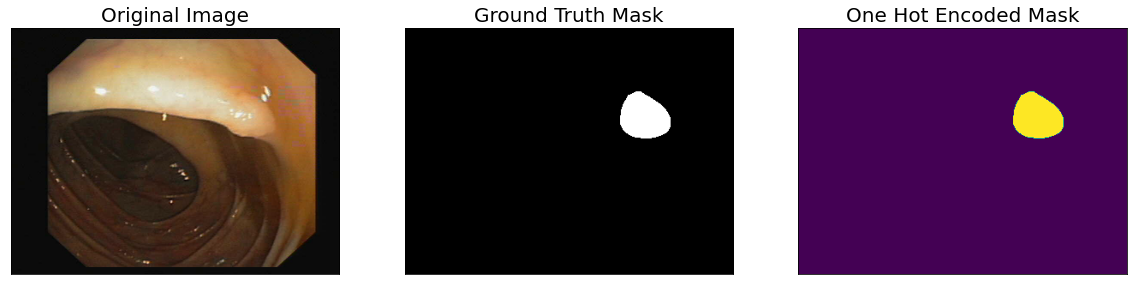

In [ ]:
dataset = EndoscopyDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    
    test_transform = [
        album.PadIfNeeded(min_height=288, min_width=384, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

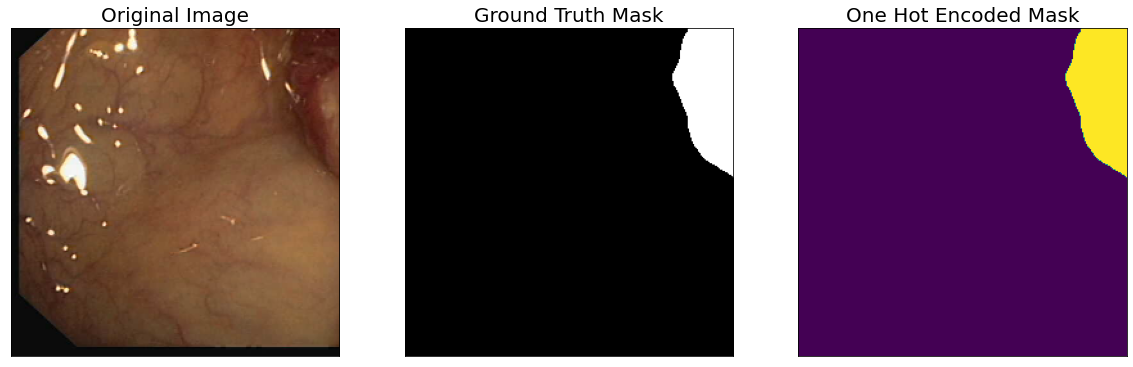

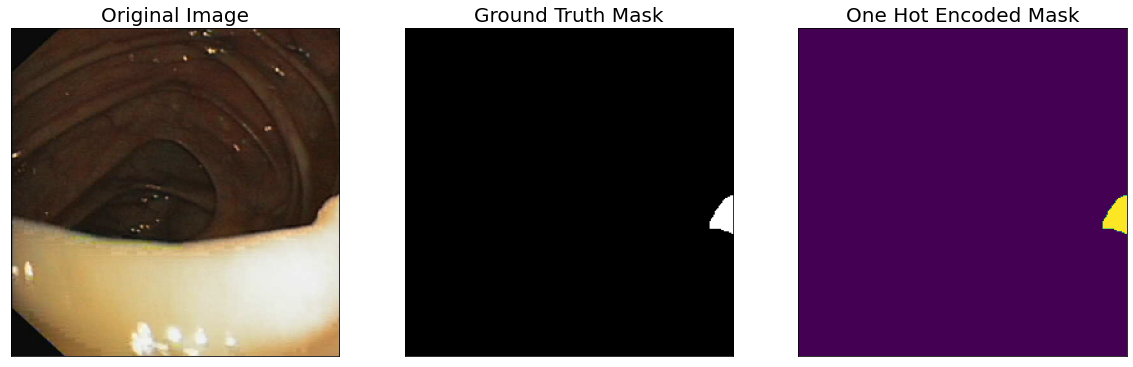

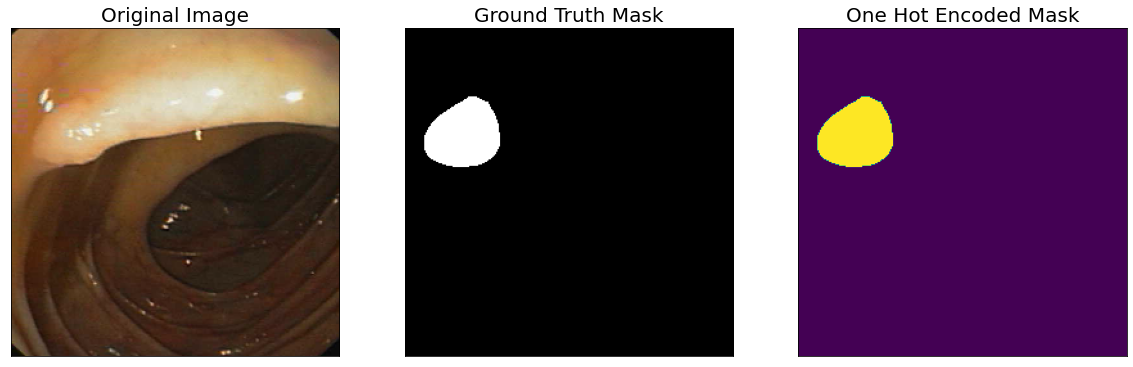

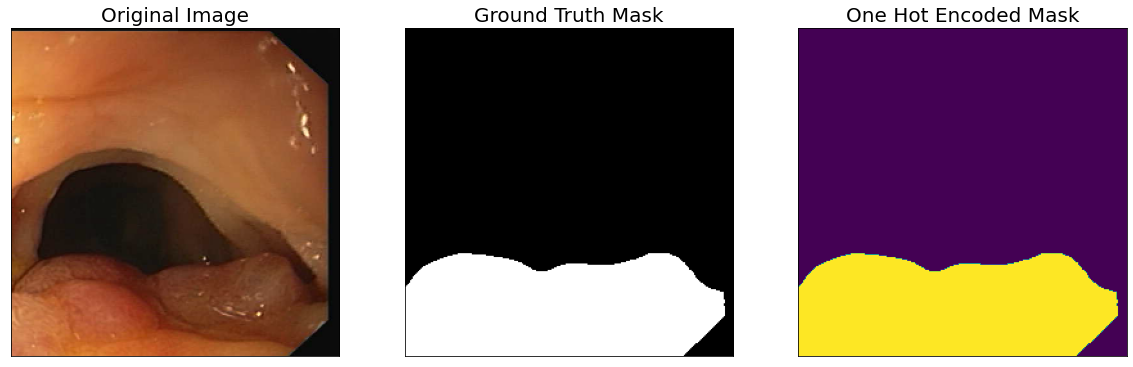

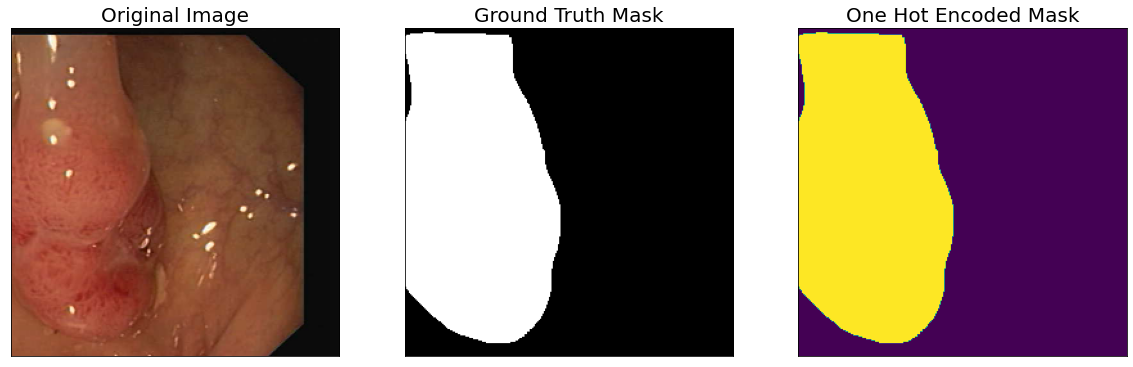

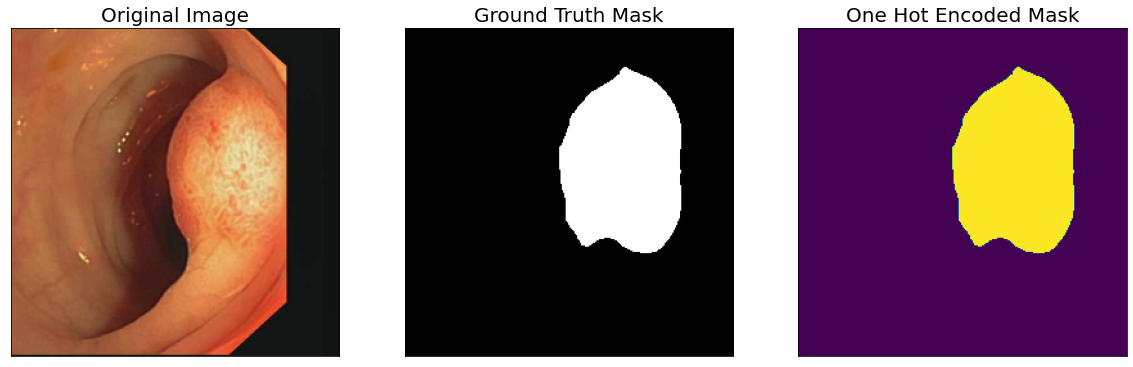

In [ ]:
augmented_dataset = EndoscopyDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

for idx in range(6):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

Training DeepLabV3+

In [ ]:
!pip install segmentation_models_pytorch 

import segmentation_models_pytorch as sm

     |████████████████████████████████| 87 kB 5.0 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
     |████████████████████████████████| 376 kB 29.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=8d195055832d7c6f88223a4a375091790b14d3291c198ac13cc0a5f098589494
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ee8e63f3a86123321b0ad43d6587a1a5ca0aef93cba7438b5be7eb7006a1522b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'



model = sm.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)



preprocessing_fn = sm.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)




In [ ]:



TRAINING = True

EPOCHS = 10







loss = sm.utils.losses.DiceLoss()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


metrics = [
    sm.utils.metrics.IoU(threshold=0.5),
    
]


optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00009),
])




In [ ]:
train_epoch = sm.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = sm.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
train_dataset = EndoscopyDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = EndoscopyDataset(
    valid_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it, dice_loss - 0.3499, iou_score - 0.8382]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, dice_loss - 0.1909, iou_score - 0.9]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, dice_loss - 0.1573, iou_score - 0.924]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, dice_loss - 0.132, iou_score - 0.9372]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, dice_loss - 0.1069, iou_score - 0.9505]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, dice_loss - 0.08513, iou_score - 0.959]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, dice_loss - 0.07517, iou_score - 0.9592]
Model saved!

Epoch: 7
valid: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, dice_loss - 0.0655, iou_score - 0.9541]

Epoch: 8
valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, dice_loss - 0.06403, iou_s

In [ ]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded Deeplabv3+ model from this run.')

Loaded Deeplabv3+ model from this run.


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2  ...         7         8         9
dice_loss  0.379651  0.247798  0.194254  ...  0.074602  0.068346  0.059384
iou_score  0.599015  0.812138  0.872249  ...  0.952496  0.949622  0.955540

[2 rows x 10 columns]

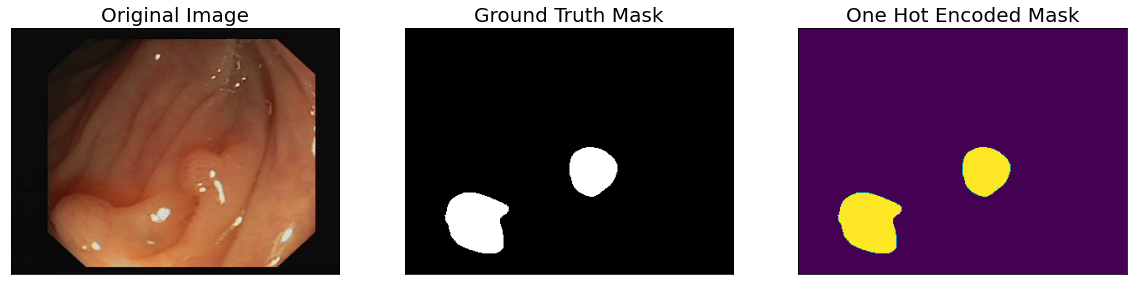

In [ ]:
test_dataset = EndoscopyDataset(
    valid_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)


test_dataset_vis = EndoscopyDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)


random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

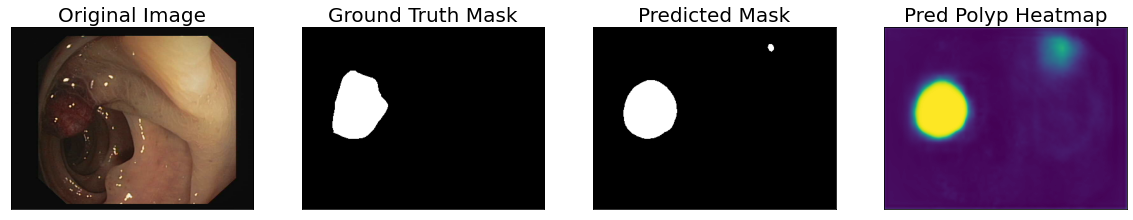

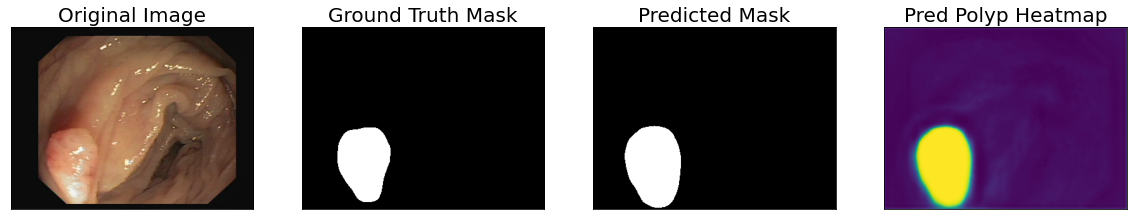

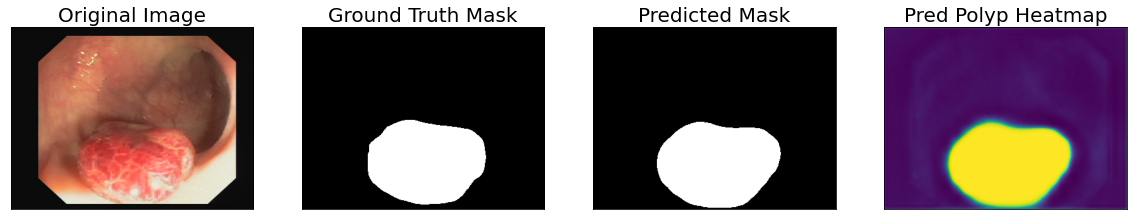

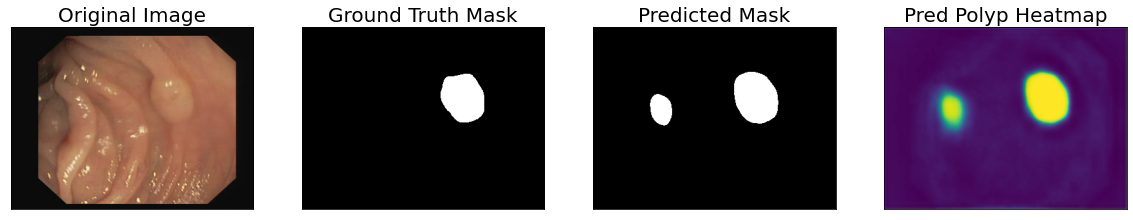

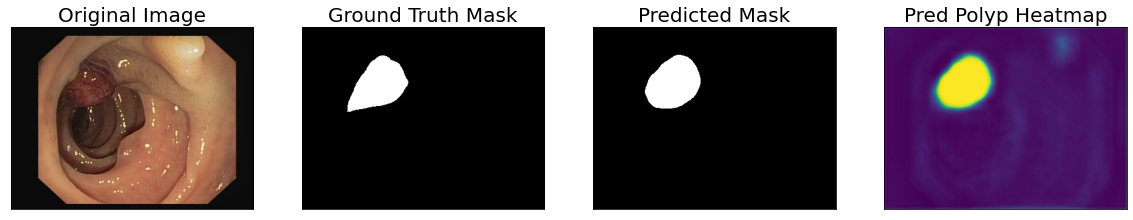

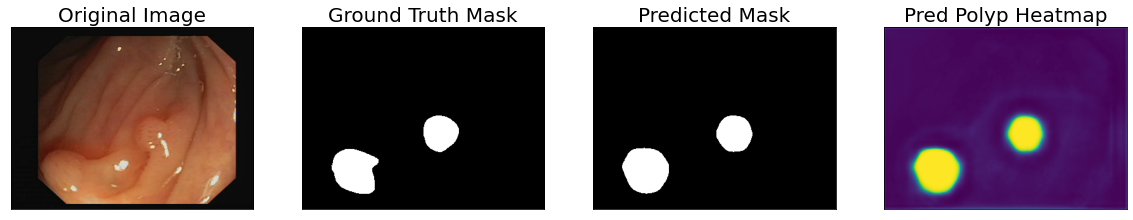

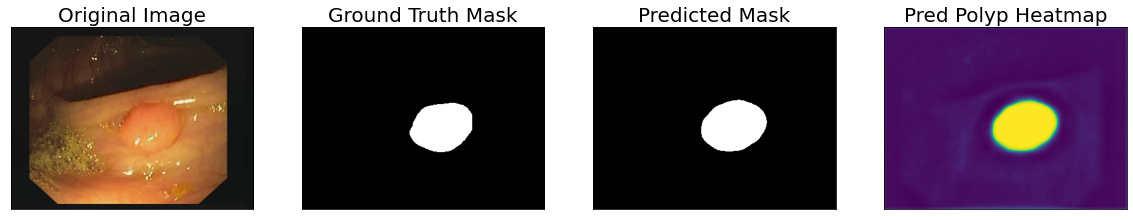

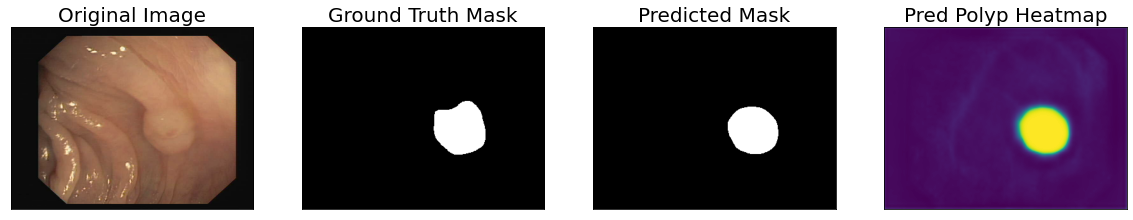

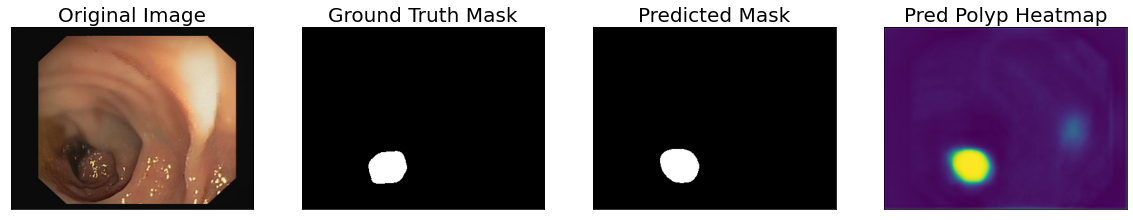

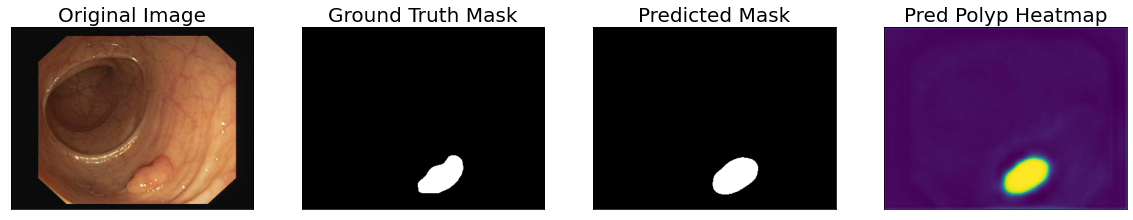

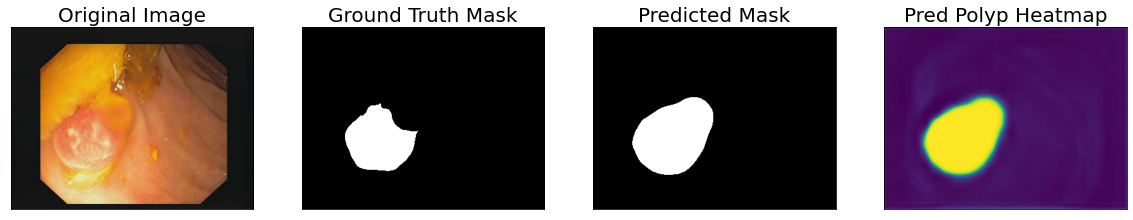

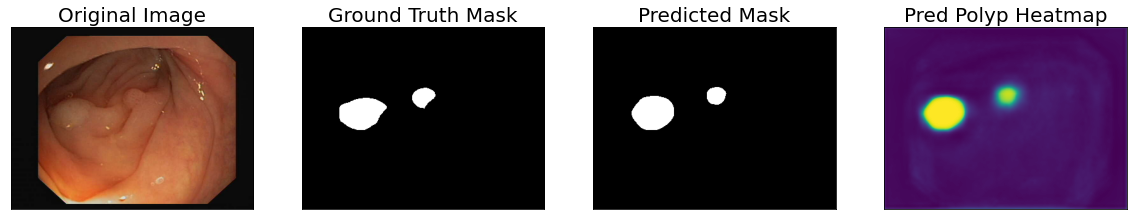

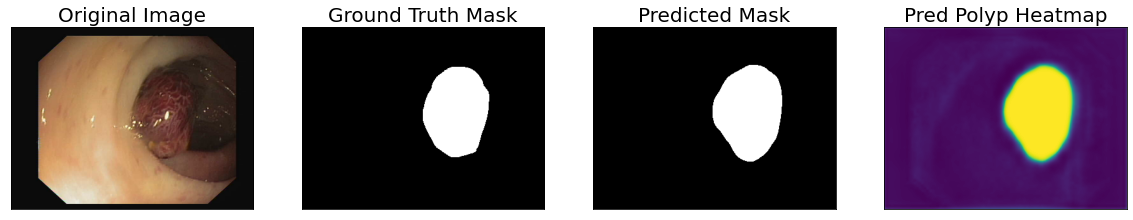

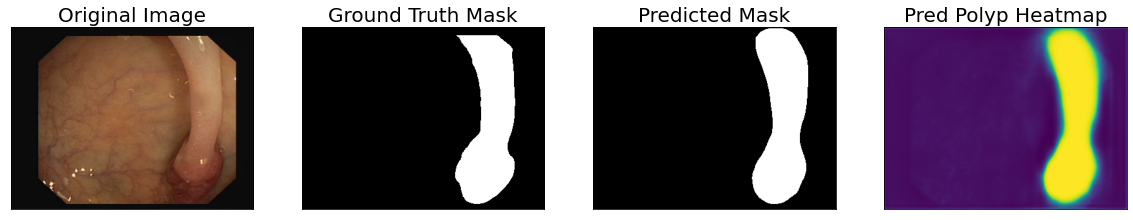

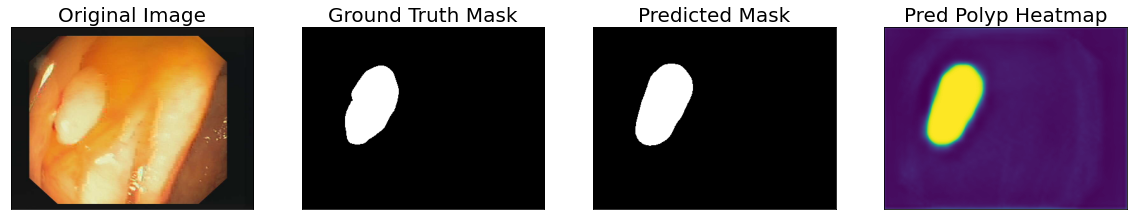

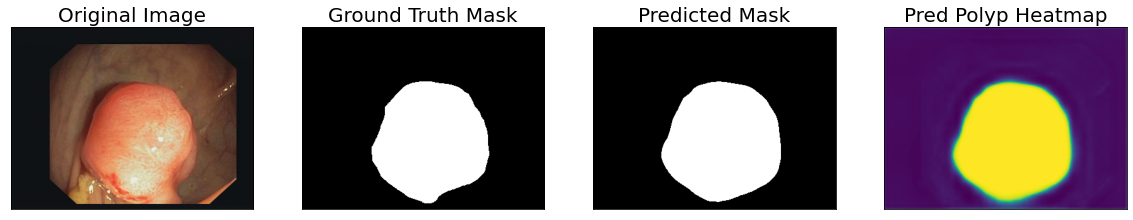

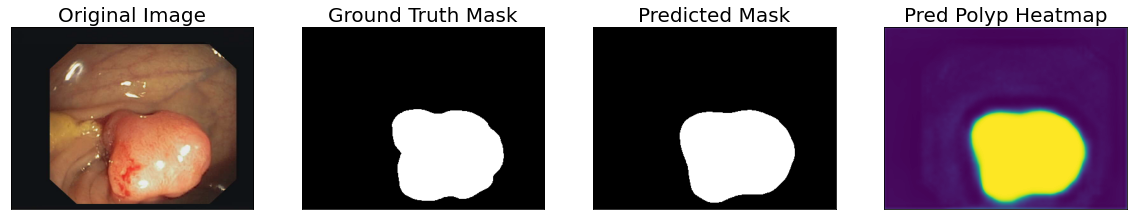

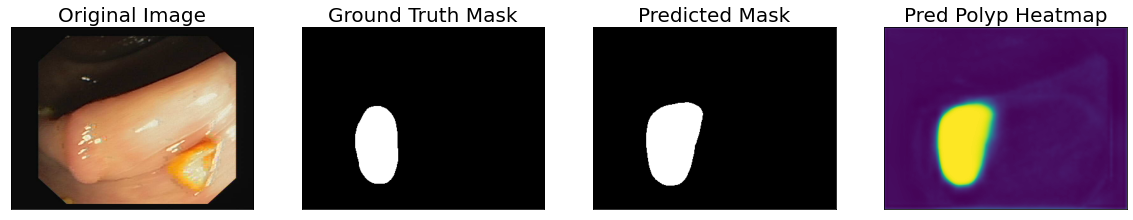

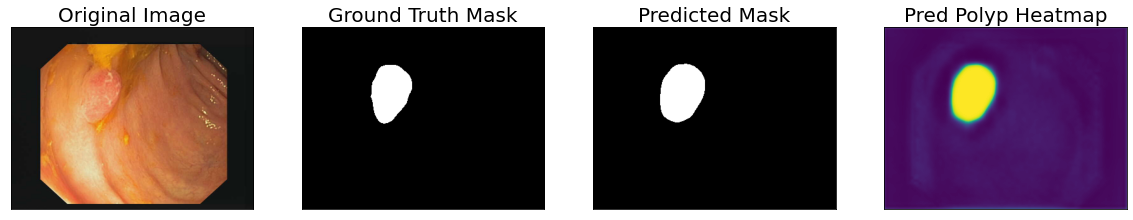

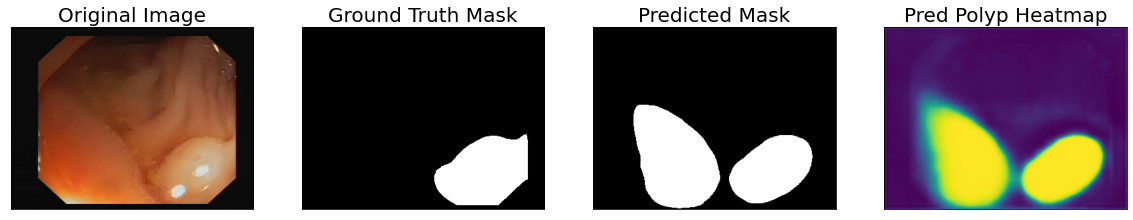

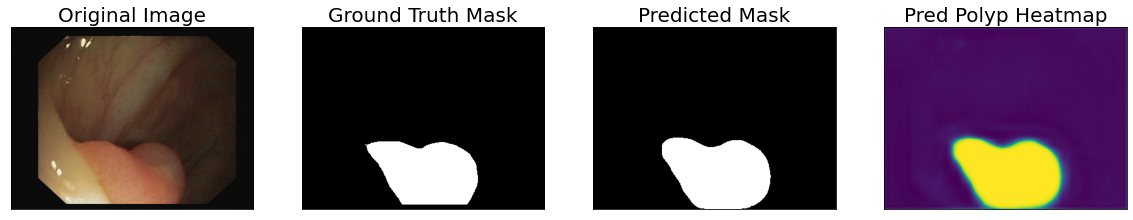

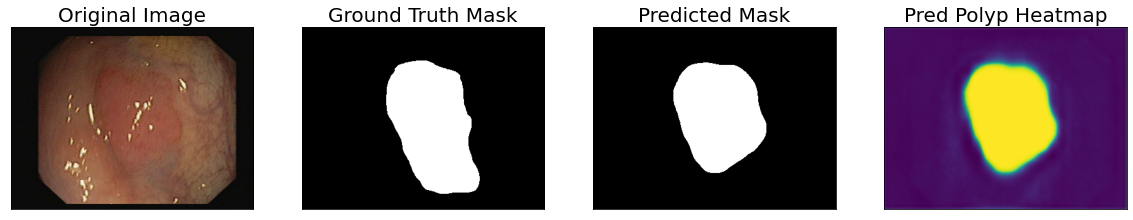

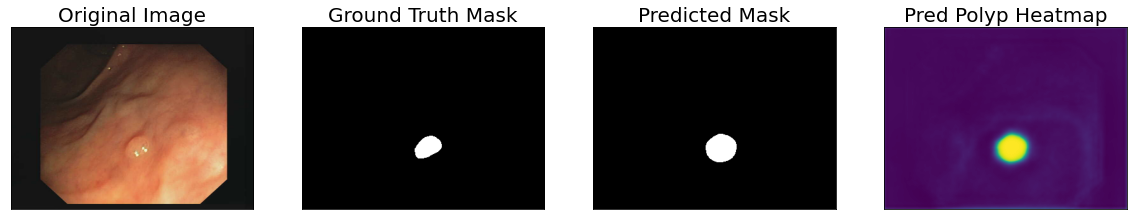

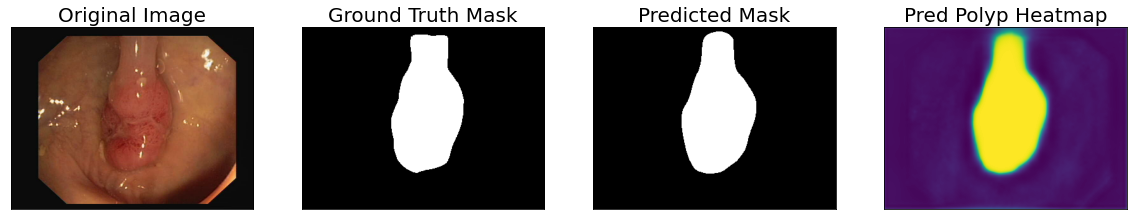

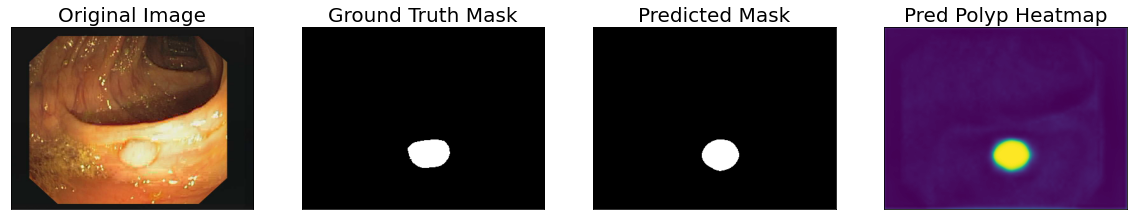

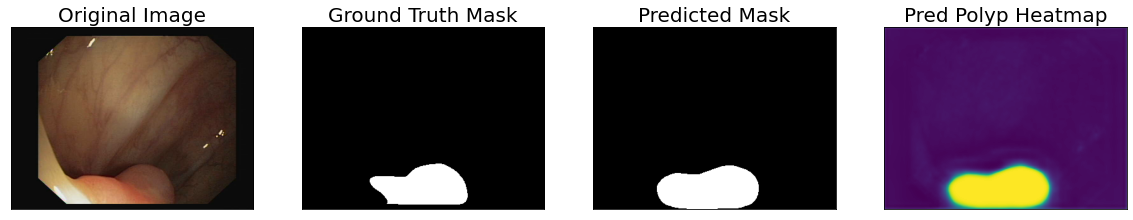

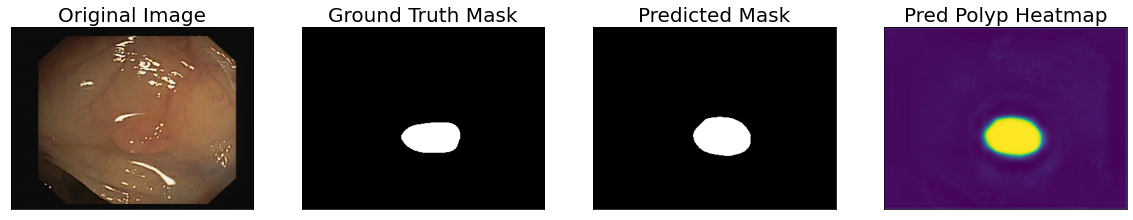

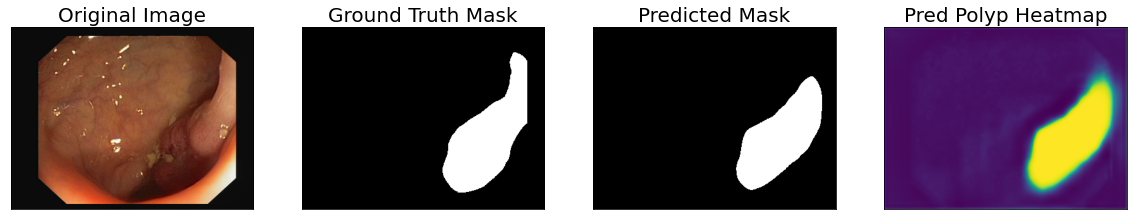

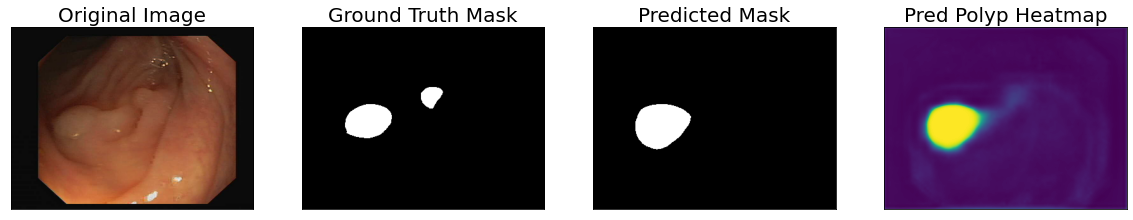

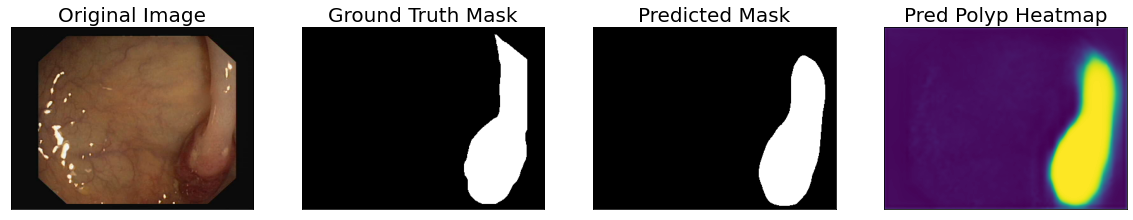

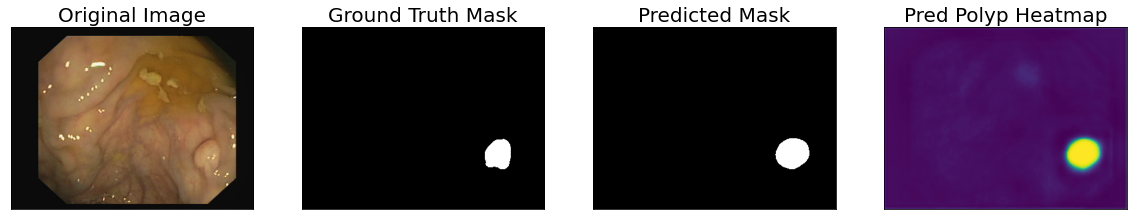

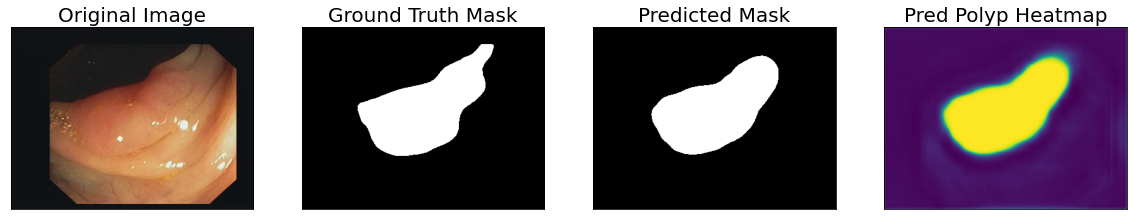

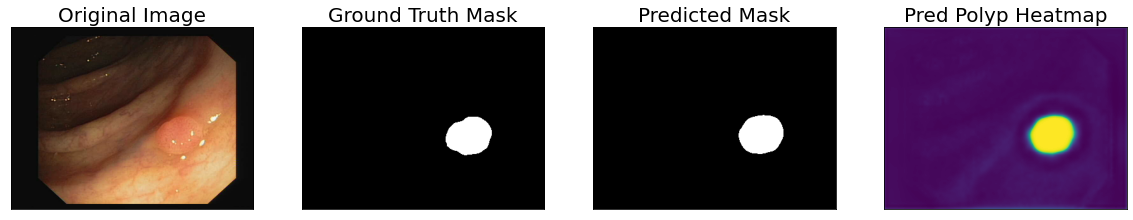

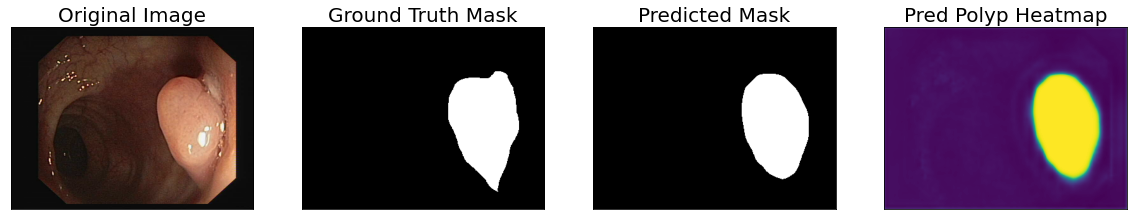

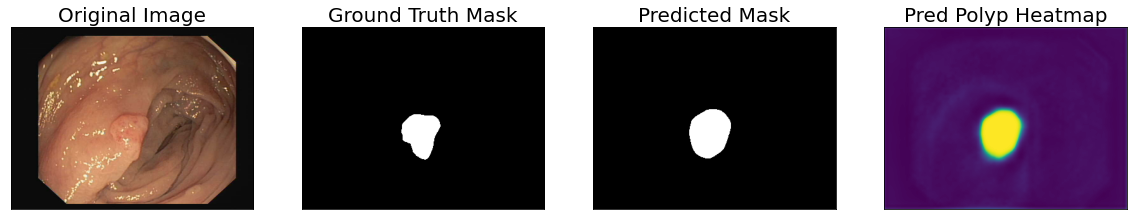

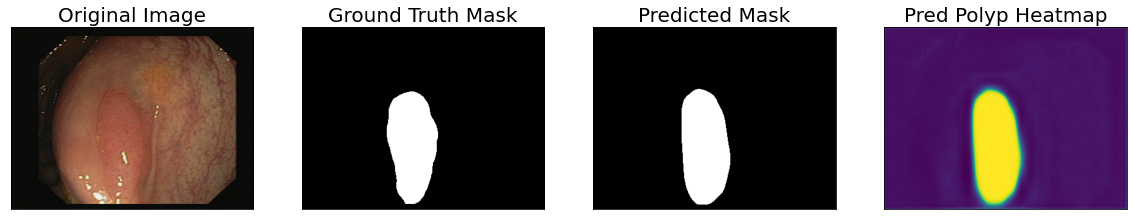

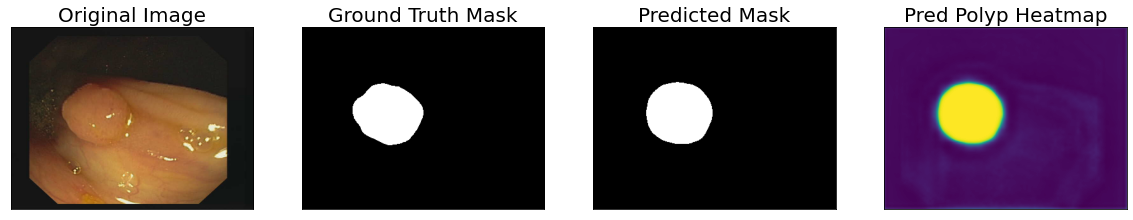

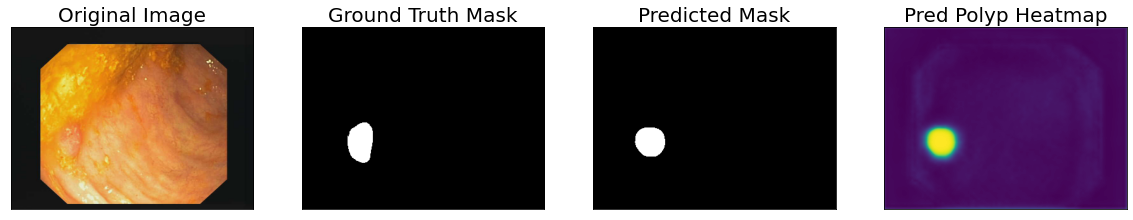

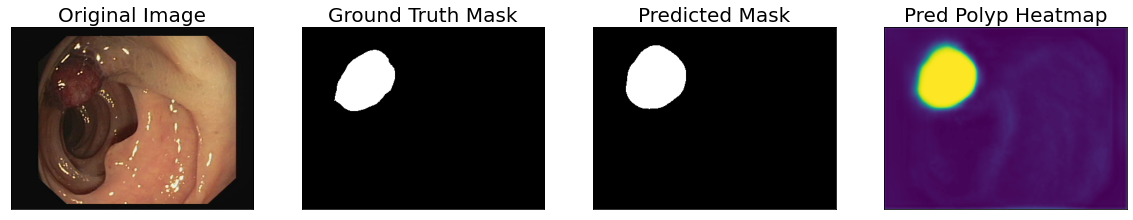

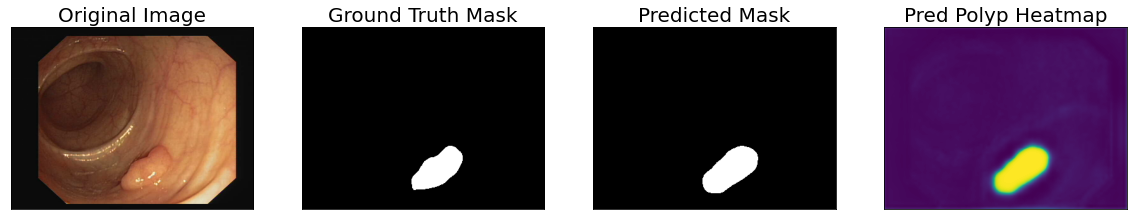

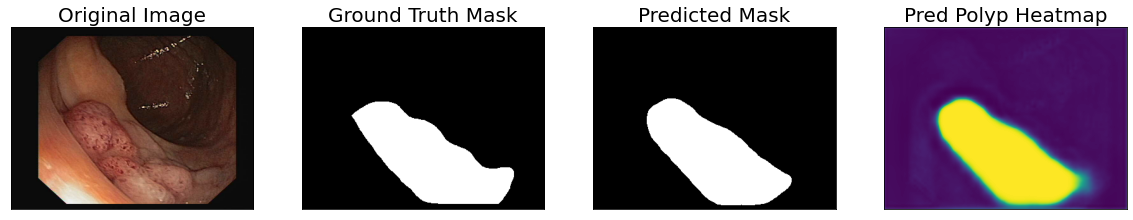

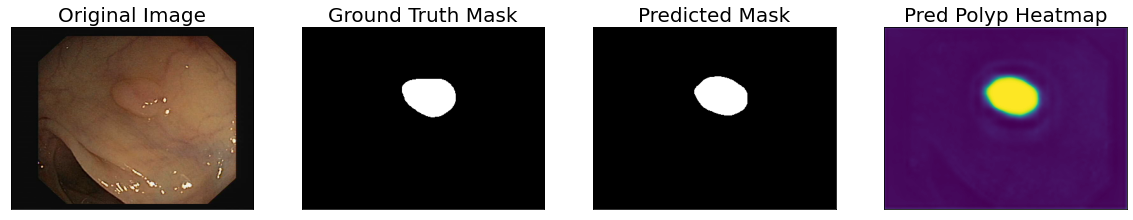

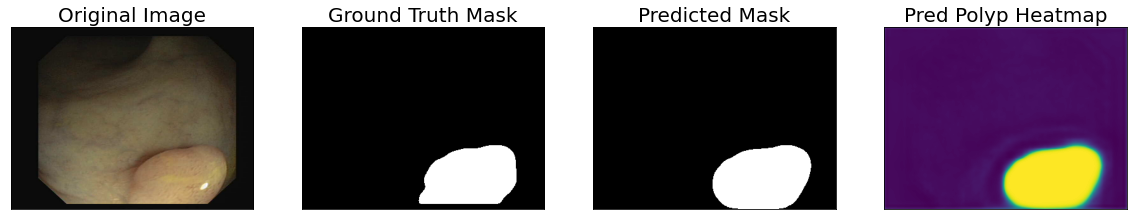

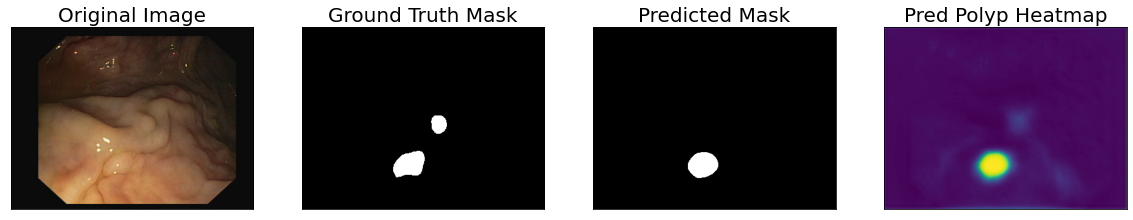

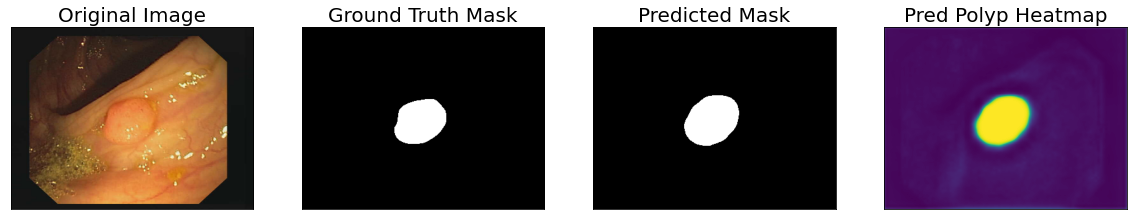

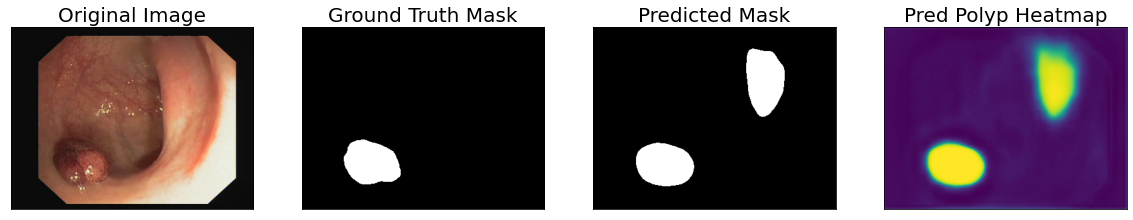

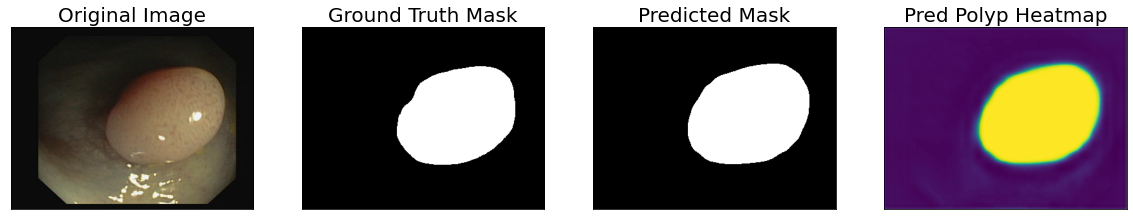

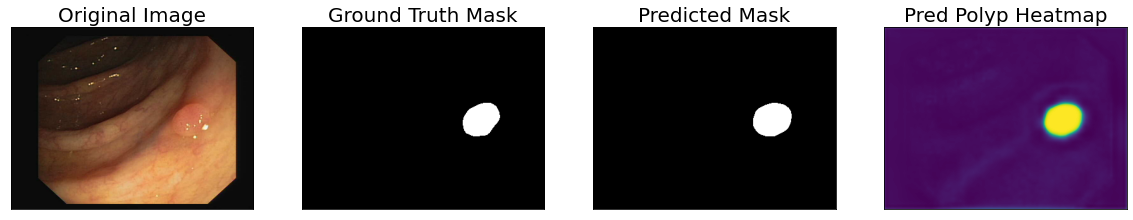

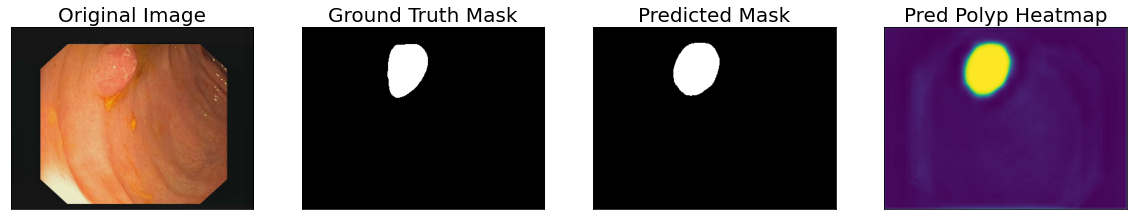

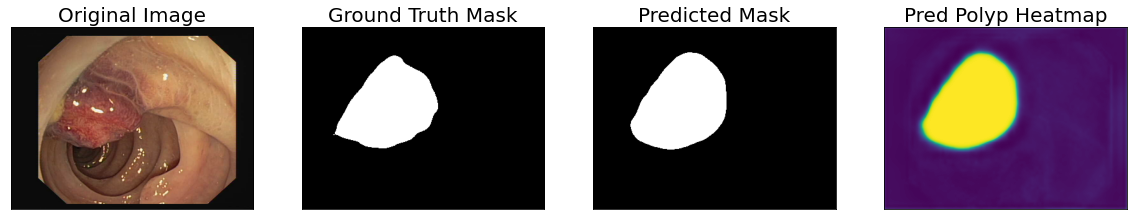

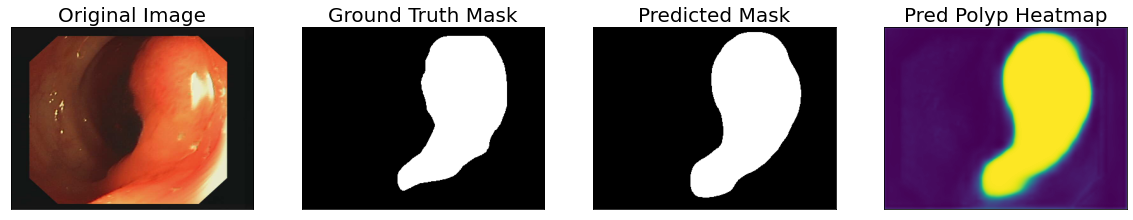

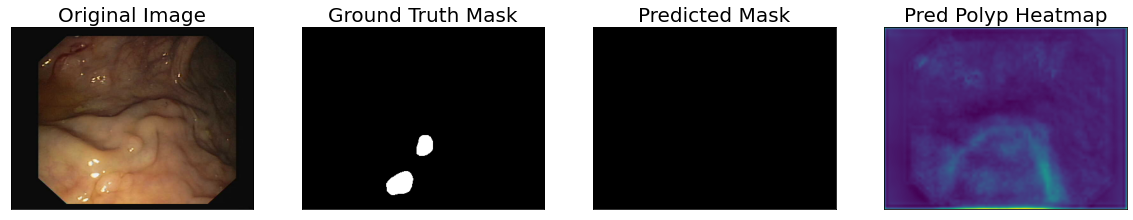

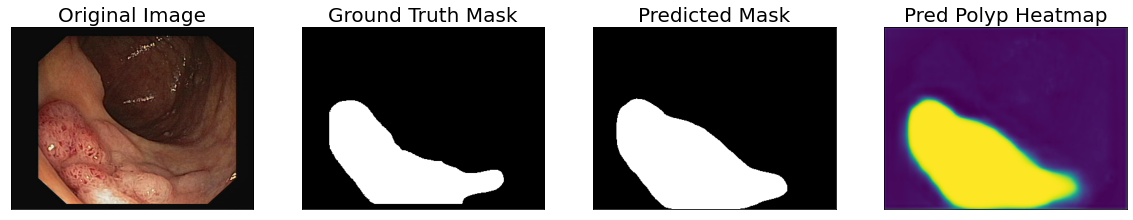

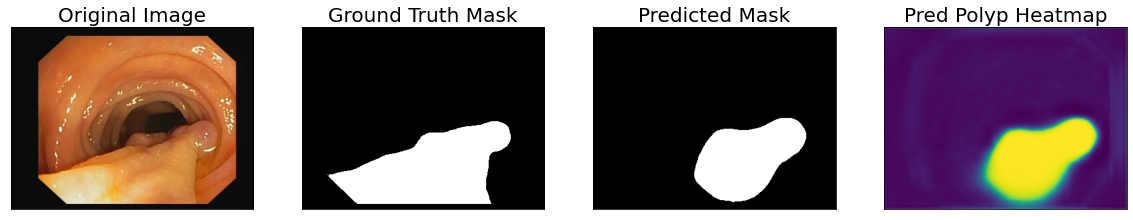

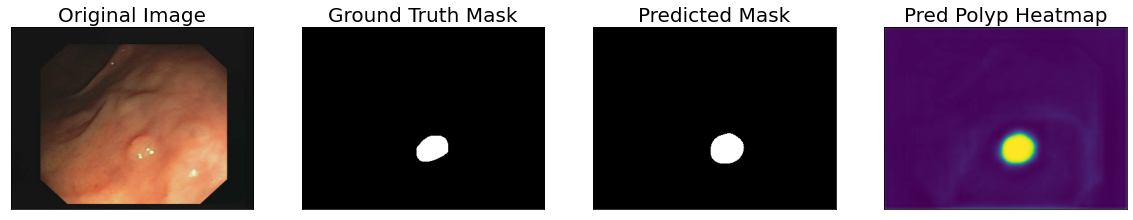

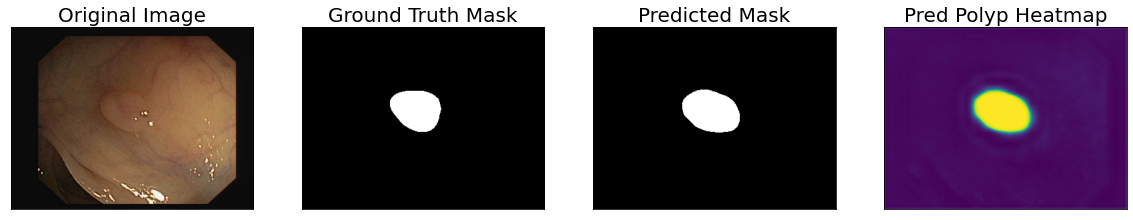

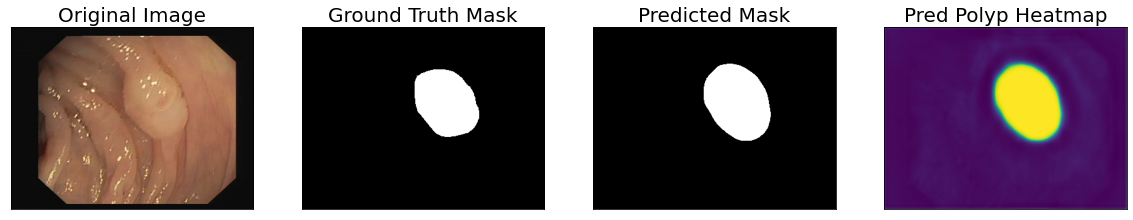

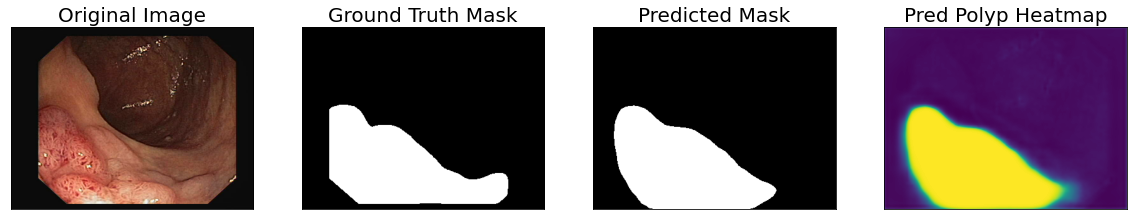

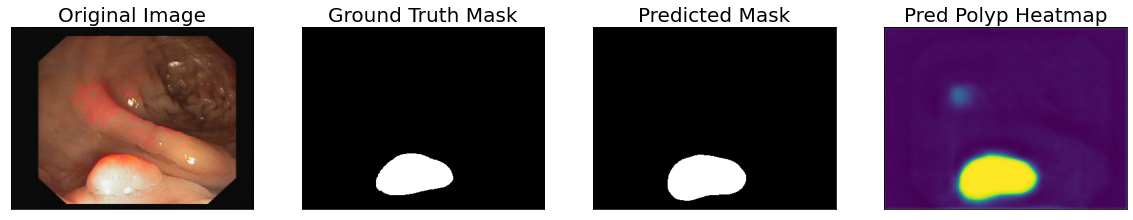

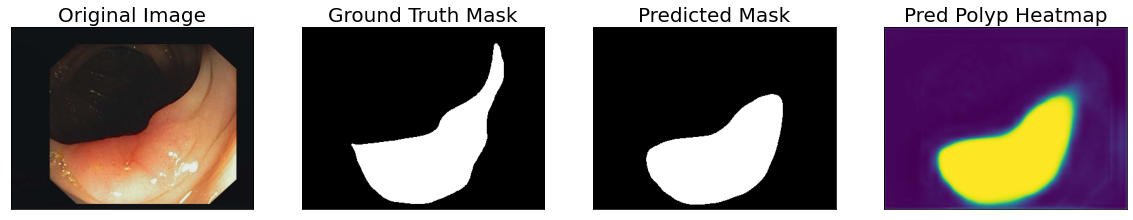

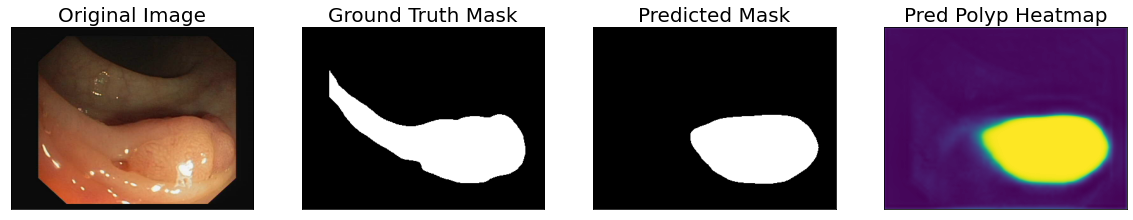

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
   
    pred_mask = np.transpose(pred_mask,(1,2,0))
    
    pred_polyp_heatmap = crop_image(pred_mask[:,:,select_classes.index('polyp')], true_dimensions)['image']
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
   
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_polyp_heatmap = pred_polyp_heatmap
    )

In [ ]:
test_epoch = sm.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 61/61 [00:02<00:00, 23.08it/s, dice_loss - 0.0534, iou_score - 0.9607]
Evaluation on Test Data: 
Mean IoU Score: 0.9607
Mean Dice Loss: 0.0534


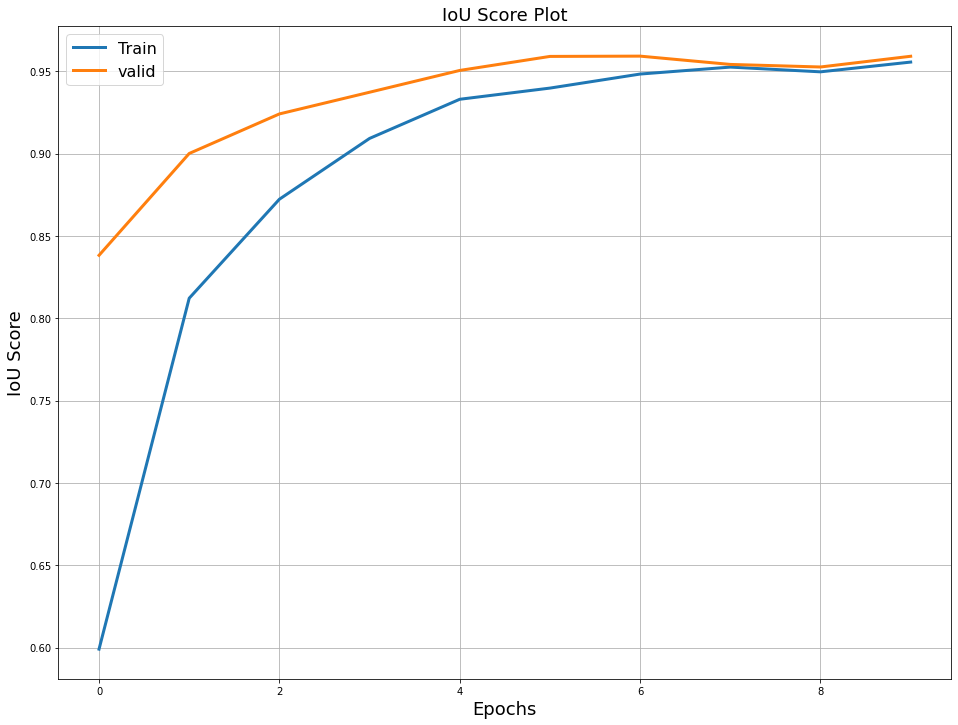

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'valid')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('IoU Score', fontsize=18)
plt.title('IoU Score Plot', fontsize=18)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

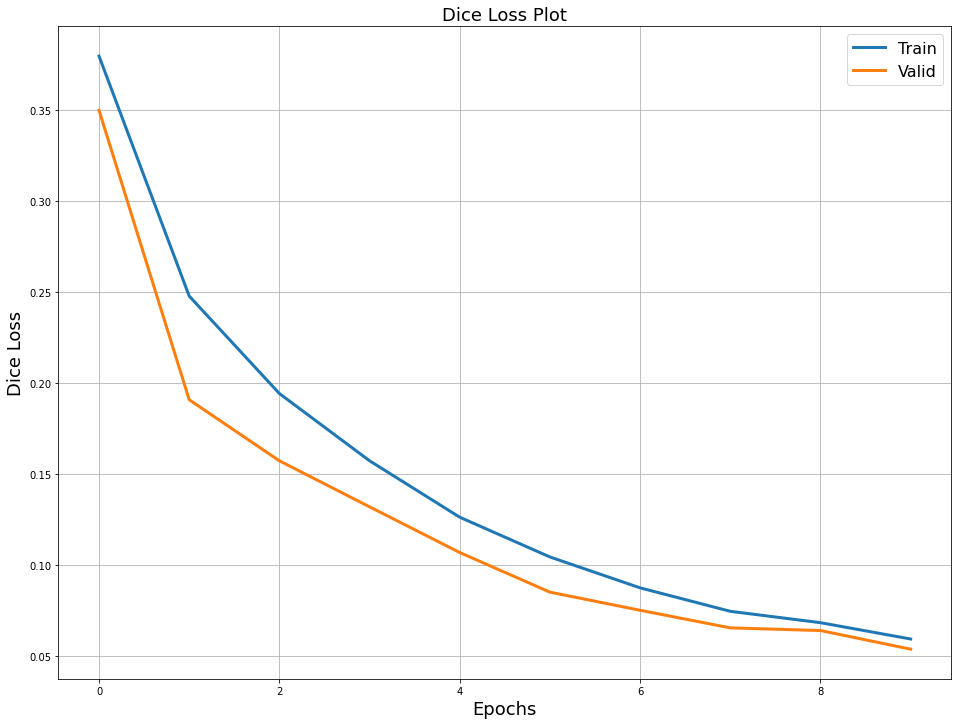

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Dice Loss', fontsize=18)
plt.title('Dice Loss Plot', fontsize=18)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()